### The objective of this script is to predict the percentage change of the BTC close in hours

In [1]:
# Array manipulations
import numpy as np

# Dataframe and its manipulations
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from matplotlib import pyplot

# Indicators from talib
import talib

# Keras - Tensorflow
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras import layers, models, metrics

# Ignore warning
import warnings  # to ignore warnings messages
warnings.filterwarnings('ignore')

### Load dataset

In [2]:
# Data comes from binance
data1 = pd.read_csv(
    '/Users/matthieusimeoni/Desktop/btc_algo/crypto_data/BTCUSDT_1h.csv')
data1.pop('Unnamed: 0')  # delete this column

# Function to convert the date 01/04/2013 => 2013-04-01
def convert_date(date):
    date_as_string = str(date)  # cast to string
    list_date = date_as_string.split('/')
    list_date.reverse()
    new_date = '-'.join(list_date)
    return new_date

# Convert date
data1['Date'] = data1['Date'].apply(convert_date)
data1['Datetime'] = pd.to_datetime(
    data1['Date'] + ' ' + data1['Time'],
    format='%Y/%m/%d %H:%M:%S')  # column datetime

# Keep the data needed
df1 = data1[['Date', 'High', 'Low', 'Open', 'Close', 'Volume']]
df1.set_index('Date', drop=True, inplace=True
             )  # time-series data, it is best to set the date column as index

print(df1.head())

               High      Low     Open    Close     Volume
Date                                                     
2017-08-17  4313.62  4261.32  4261.48  4308.83  47.181009
2017-08-17  4328.69  4291.37  4308.83  4315.32  23.234916
2017-08-17  4345.45  4309.37  4330.29  4324.35   7.229691
2017-08-17  4349.99  4287.41  4316.62  4349.99   4.443249
2017-08-17  4377.85  4333.32  4333.32  4360.69   0.972807


### Add features

In [3]:
# Create a column for price changes
df1['Per. change'] = df1.Close.pct_change() # pct_change() find the percentage change
df = df1.dropna(inplace=False) # drop all null/NaN values

# Add RSI with Talib
df['RSI'] = talib.RSI(df.Close, timeperiod=14)

<AxesSubplot:xlabel='Date'>

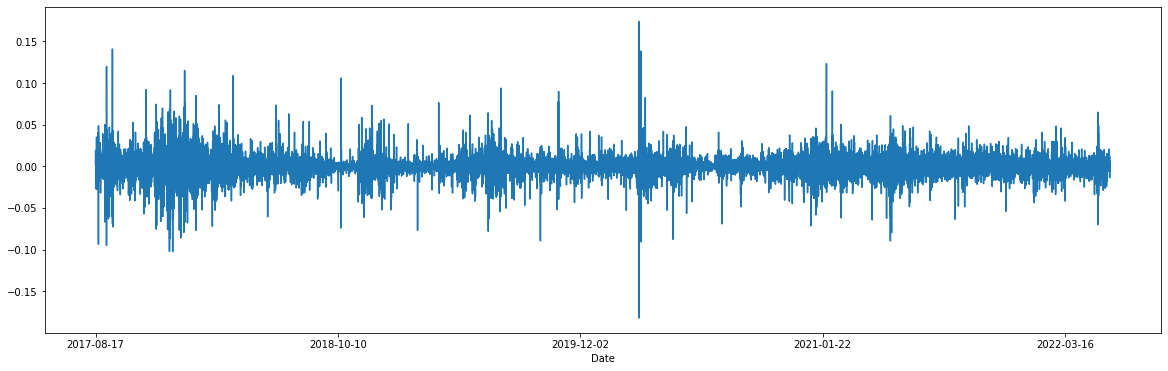

In [4]:
# Per. change price curve
df['Per. change'].plot(figsize = (20, 6))
# Note : oscillate around the mean value zero => stationarity

### Features selection

In [5]:
# Drop first rows nan because of the time period RSI
df = df[14:]

# Data of interest
x_values = df[[
    'Per. change',
    'Volume',
    'RSI'
]].values

### Normalization

In [6]:
# Data normalization 
from sklearn.preprocessing import MinMaxScaler

# Scaler
scaler = MinMaxScaler(feature_range=(0, 1)).fit(
    x_values)  # data normalization between 0 and 1 and training
x_scaled = scaler.transform(x_values)  # transform our data X

### Split the data to train and test set

In [7]:
# Training the model outputs

# select target
y = [x[0] for x in x_scaled]  # select the Close price column only because it is what we want to predict

# select features
x_scaled = x_scaled[:, 1:]

# 80% training set and 20% test set
per_train = int(len(x_scaled)*0.9) # choose the train set

# train and test set (can not use train_test_split because the prediction differe day after day)
x_train = x_scaled[:per_train]  # 80% only features (not only Per. change)
y_train = y[:per_train] # 80% only Per. change

x_test = x_scaled[per_train:]  # 20% features
y_test = y[per_train:] # 20% only Close price

# Check the dimension
if len(x_train) == len(y_train) and len(x_test) == len(y_test):
    print('Good dimensions')
else:
    print('Too bad...')

Good dimensions


### We use the last hour to predict the next hour for every 2 hours (to not overlap hours)

In [8]:
# label the model
time_step = 1 # time step for the LSTM model

xtrain = [] # both
ytrain = [] # only Close

xtest = [] # both
ytest = [] # only Close

i = time_step
while i < len(x_train): # from time_step to the len of x_train
    # we want to use the last time_step days data to predict the next hour
    xtrain.append(x_train[i-time_step:i,:x_train.shape[1]]) 
    ytrain.append(y_train[i]) 
    i+=2 # skip the hour that we use to predict the next one and also the hour predict to never overlap hours

i = time_step
while i < len(y_test):  # same thing but for the test set
    xtest.append(x_test[i-time_step:i,:x_test.shape[1]])
    ytest.append(y_test[i])
    i+=2

# check shape of out train data
print(np.array(xtrain).shape) # (nb obs, nb seq, nb features)
print(len(df))
print((len(ytrain) + len(ytest)) * 2) # we miss one value compare to df
print(xtrain[0])
print(ytrain[0])

(18829, 1, 2)
41843
41842
[[0.00098847 0.50576591]]
0.5255947468214774


In [9]:
# Important, check that we took the last value of the train set
if ytrain[-1] != y_train[-1]:
    print('We miss value(s) of the train set')
    print(ytrain[-4:])  # last value should be
    print(y_train[-4:])  # the first value of this print in the array
    
# Important, check that we took the last value of the test set
if ytest[-1] != y_test[-1]:
    print('We miss value(s) of the test set')
    print(ytest[-2:]) # last value should be
    print(y_test[-2:]) # the first value of this print in the array

We miss value(s) of the test set
[0.5243377130038579, 0.49894965912066797]
[0.49894965912066797, 0.5104837966111158]


### Create the neural network

In [10]:
# LSTM

# adapt the input structure for LSTM => reshape
xtrain, ytrain = np.array(xtrain), np.array(ytrain) # train set
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], xtrain.shape[2])) # reshape to be sure

xtest, ytest = np.array(xtest), np.array(ytest) # test set
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], xtest.shape[2]))  # reshape to be sure

# MAPE metric
metric = metrics.MAPE

# Create the model
model = models.Sequential()
model.add(
    layers.LSTM(32,
                return_sequences=False,
                activation='tanh',
                input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[metric])
history = model.fit(xtrain,
                    ytrain,
                    validation_split=0.3,
                    epochs=25,
                    batch_size=16,
                    verbose=1)

2022-06-28 19:54:33.620531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25
824/824 [==============================] - 5s 3ms/step - loss: 0.0069 - mean_absolute_percentage_error: 7.3851 - val_loss: 5.9512e-04 - val_mean_absolute_percentage_error: 3.1899
Epoch 2/25
824/824 [==============================] - 2s 2ms/step - loss: 8.4907e-04 - mean_absolute_percentage_error: 3.6135 - val_loss: 6.0467e-04 - val_mean_absolute_percentage_error: 3.2614
Epoch 3/25
824/824 [==============================] - 2s 2ms/step - loss: 8.4284e-04 - mean_absolute_percentage_error: 3.5586 - val_loss: 7.8785e-04 - val_mean_absolute_percentage_error: 4.1186
Epoch 4/25
824/824 [==============================] - 2s 2ms/step - loss: 8.3340e-04 - mean_absolute_percentage_error: 3.5385 - val_loss: 5.9584e-04 - val_mean_absolute_percentage_error: 3.1736
Epoch 5/25
824/824 [==============================] - 2s 2ms/step - loss: 8.3311e-04 - mean_absolute_percentage_error: 3.5387 - val_loss: 5.9207e-04 - val_mean_absolute_percentage_error: 3.1883
Epoch 6/25
824/824 [==============

### Plot train and validation loss

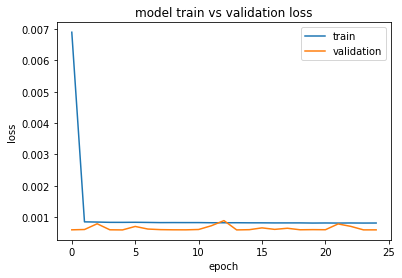

In [11]:
# Plot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

### Evaluate the model on test set

In [12]:
model.evaluate(xtest, ytest)

66/66 [==============================] - 0s 1ms/step - loss: 3.9685e-04 - mean_absolute_percentage_error: 2.5955


[0.00039684755029156804, 2.5955371856689453]

### Make the predictions

In [13]:
# Prediction
train_predict = model.predict(xtrain) # with training set X predict training set Y (on which LSTM has been trained)
test_predict = model.predict(xtest) # with test set X predict test set Y (on which LSTM has NOT been trained)

66/66 [==============================] - 0s 1ms/step


In [14]:
# Prediction
train_predict = model.predict(
    xtrain
)  # with training set X predict training set Y (on which LSTM has been trained)
test_predict = model.predict(
    xtest
)  # with test set X predict test set Y (on which LSTM has NOT been trained)

# Inverse transform our data to obtain the values in the right scale (since it was initially normalized)
train_predict_trans = train_predict
test_predict_trans = test_predict

# Make the good dimension to use the scaler
for n in range(0, xtrain.shape[2]): 
    train_predict_trans = np.c_[train_predict_trans,
                                np.zeros(train_predict.shape)]
    test_predict_trans = np.c_[test_predict_trans,
                                np.zeros(test_predict.shape)]

# reassign variables
train_predict = train_predict_trans
test_predict = test_predict_trans

# inverse transform our data
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

66/66 [==============================] - 0s 1ms/step


### Horizontal fusion of the predictions

In [15]:
# fusion of all the prediction : from the train and the test
predict_btc = np.hstack([train_predict[:,0], test_predict[:,0]])  # horizontal fusion

In [16]:
# to predict the close with the per. change, we need the close from the hour before our prediction
close_before_pred = []
i = 0
while i < len(df.Close.values):
    close_before_pred.append(df.Close.values[i])
    i += 2
close_before_pred = np.array(close_before_pred[:-1])  # [:-1] because we dont have the last prediction in the test set
print(f'Total len of the closes needed before predictions : {len(close_before_pred)}')

# Use our prediction (per. change) to predict the close
def inverse_per_change(per, what_it_was):
    return (per * what_it_was) + what_it_was

predict_btc_close = inverse_per_change(predict_btc, close_before_pred)

Total len of the closes needed before predictions : 20921


In [17]:
# The real close of the btc
real_close = []
real_per_change = []
i = 1
while i < len(df.Close.values):
    real_close.append(df.Close.values[i])
    real_per_change.append(df['Per. change'].values[i])
    i += 2
    
real_close = np.array(real_close)

### Plot our prediction and the reality

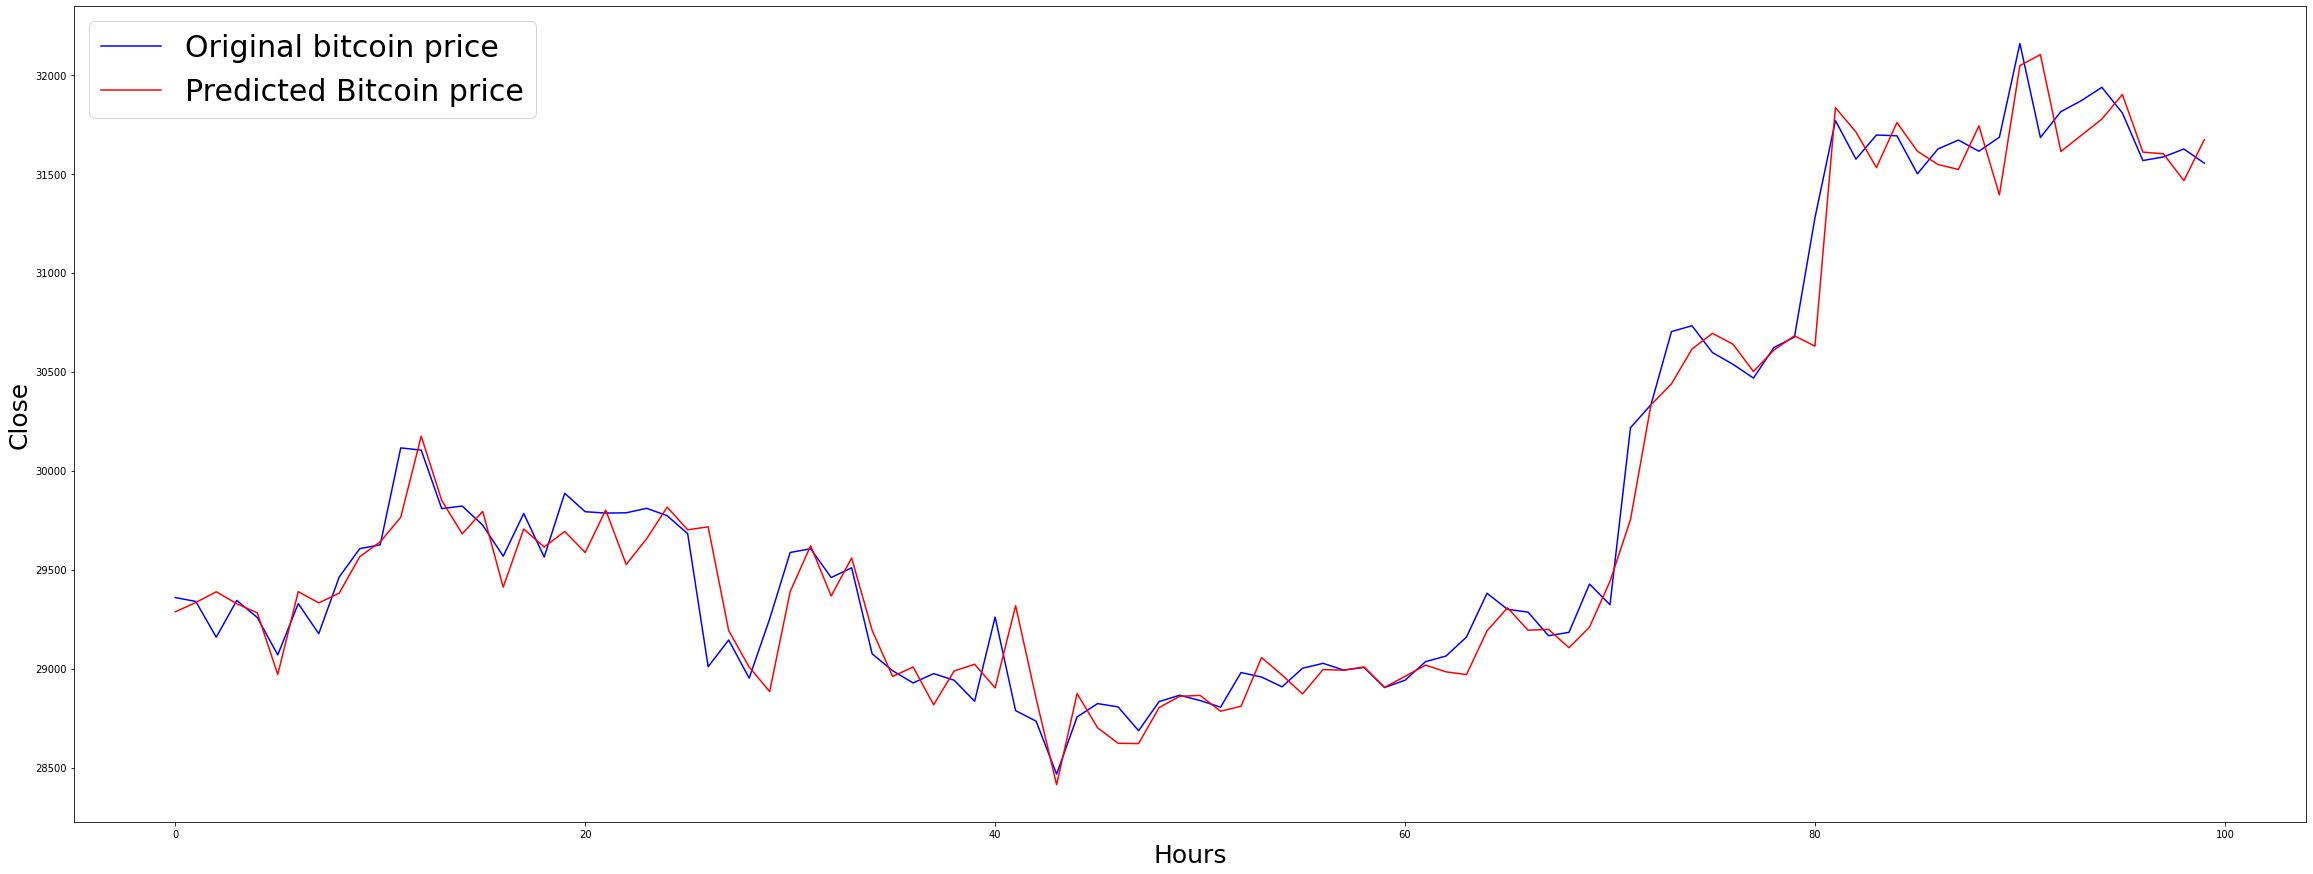

In [18]:
fig, ax = plt.subplots(figsize=(40, 15))

ax.plot(real_close[-100:], 'blue', label='Original bitcoin price') # for the last 100 obs
ax.plot(predict_btc_close[-100:], 'red', label='Predicted Bitcoin price')
ax.set_xlabel('Hours', fontsize=25)
ax.set_ylabel('Close', fontsize=25)
plt.legend(fontsize=30)

In [19]:
# Compare up and down per change
predict_btc_binary = [1 if x > 0 else 0 for x in predict_btc[-100:]]
real_btc_binary = [1 if x > 0 else 0 for x in real_per_change[-100:]]

count = [0 for a, b in zip(predict_btc_binary, real_btc_binary) if a == b]
print(
    f'Percentage of correct binary predictions : {len(count)*100 / len(real_btc_binary)}'
)

Percentage of correct binary predictions : 58.0
